# 1. Import Library

In [36]:
import pandas as pd #untuk Dataframe
import re #Untuk Remove Punct
import numpy as np #untuk perhitungan
import random #untuk set seed sample

#Untuk Tokenization
import nltk
nltk.download('punkt')

#word embedding lib
from gensim.models import FastText 

#Data Visualitaion
import seaborn as sns #Untuk visualisasi
import matplotlib.pyplot as plt #Untuk visualisasi

#imbalanced Dataset
from imblearn.over_sampling import SMOTE #Untuk Oversampling


#Modeling Classifier
from sklearn.model_selection import train_test_split #Untuk mebagi data menjadi Train Dan Test
from sklearn.neighbors import KNeighborsClassifier #KNN Algo

#Evaluate
from sklearn.model_selection import cross_val_score # CrossFold Validation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay#Untuk Membuat Confusion Matrix
from sklearn.model_selection import GridSearchCV # Parameter Tunning

#Export model
from joblib import dump

[nltk_data] Downloading package punkt to C:\Users\Ibrahim
[nltk_data]     Saputra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 2. Import Dataset

In [37]:
df = pd.read_excel("dataIcon.xlsx")
print(df.shape)
df.head()

(4748, 18)


,Incident No,Status,service (Layanan berdasarkan kategori),Category,Caller,VIP,Title,Urgency,Priority,Source,Assign On (Send email to agent based on ticket),SLA (Ticketing treeshold),Created On (Admin Get email),Created By,Resolved On,Resolved By,Resolved On Agent,Resolved By Agent
0,1000129,Closed,AirCRM,Opportunity,Name*****,False,Upgrade tidak bisa,Low,4,Self Service,2020-08-28 17:18:03,False,2020-08-27 17:19:20,Name*****,2020-08-28 17:19:03,Name*****,NaN,NaN
1,1000132,Closed,AirCRM,Email Invoice,Name*****,False,Kirim Ulang Email Pembayaran,Low,4,Email,2020-08-28 17:13:56,False,2020-08-28 08:15:59,Name*****,2020-08-28 17:14:11,Name*****,NaN,NaN
2,1000133,Closed,AirCRM,Opportunity,Name*****,False,Status Aircrm,Low,4,Email,2020-09-01 14:05:23,True,2020-08-28 08:52:15,Name*****,2020-09-02 15:25:29,Name*****,NaN,NaN
3,1000138,Closed,AirCRM,VA Expired,Name*****,False,Pembayaran antar bank bermasalah,Low,4,Email,2020-08-31 09:29:35,False,2020-08-31 08:24:37,Name*****,2020-08-31 09:31:11,Name*****,NaN,NaN
4,1000139,Closed,AirCRM,Email Invoice,Name*****,False,resend email tagihan awal customer,Low,4,Email,2020-08-31 09:36:09,False,2020-08-31 08:56:04,Name*****,2020-08-31 09:36:26,Name*****,NaN,NaN


# 3. Text Extraction And Clean Up

### - Drop And Rename

In [38]:
df = df.rename(columns={'service (Layanan berdasarkan kategori)' : 'Service'})
df = df.rename(columns={'Assign On (Send email to agent based on ticket)' : 'Assign On'})
df = df.rename(columns={'Created On (Admin Get email)' : 'Created On'})
df.drop(['Resolved On','Assign On','Category','Service','Caller','Status','Source',
         'Created On','Created By','Resolved By','Resolved On Agent','Resolved By Agent','Incident No',
         'VIP','Priority','SLA (Ticketing treeshold)'],axis=1,inplace=True)
df.head()

,Title,Urgency
0,Upgrade tidak bisa,Low
1,Kirim Ulang Email Pembayaran,Low
2,Status Aircrm,Low
3,Pembayaran antar bank bermasalah,Low
4,resend email tagihan awal customer,Low


### - Remove NA Values

In [39]:
#Check apakah ada NA
df.isna().any()

Title      False
Urgency    False
dtype: bool

### - Remove Punctuation

In [40]:
# Fungsi untuk remove selain huruf dan angka seperti ()[]?}{}':;><,. dll
def rmPunct(text) :
    text = re.sub(r'[^\w\s]',' ',text) #rm punctuation
    text = re.sub(r' +',' ',text) #rm space more than 1
    return text.strip().lower() #rm leading space and make it al lowercase

In [41]:
df.Title = df.Title.map(rmPunct)
df.head()

,Title,Urgency
0,upgrade tidak bisa,Low
1,kirim ulang email pembayaran,Low
2,status aircrm,Low
3,pembayaran antar bank bermasalah,Low
4,resend email tagihan awal customer,Low


# 4. Pre-Processing

### - Imbalance Dataset Check

In [42]:
df.Urgency.value_counts()

Urgency
Low       4704
Medium      33
High        11
Name: count, dtype: int64

In [43]:
df.Urgency.value_counts() / len(df.Urgency) * 100

Urgency
Low       99.073294
Medium     0.695029
High       0.231676
Name: count, dtype: float64

<Axes: xlabel='Urgency', ylabel='Count'>

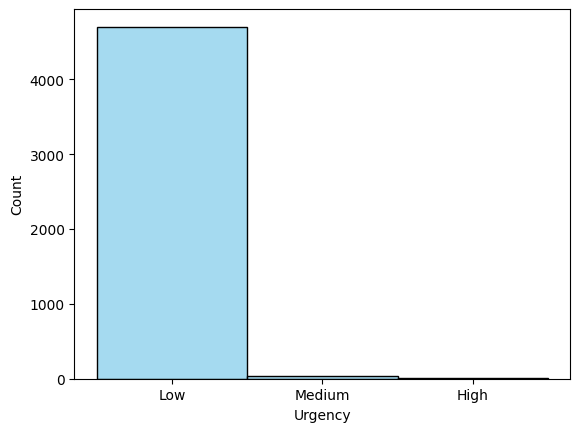

In [44]:
sns.histplot(data=df, x='Urgency', color='skyblue')

### - UnderSampling Low Urgency

In [45]:
#Ambil Df yang urgencynya Low
df_classLow = df[df['Urgency'] == 'Low']
df_classLow.head()

,Title,Urgency
0,upgrade tidak bisa,Low
1,kirim ulang email pembayaran,Low
2,status aircrm,Low
3,pembayaran antar bank bermasalah,Low
4,resend email tagihan awal customer,Low


In [46]:
#Set Seed
seed = 64
random.seed(seed)
np.random.seed(seed)

#ambil random 2000 sample (UnderSampling)
df_classLow = df_classLow.sample(2000)
df_classLow.shape

(2000, 2)

Urgency
Low       97.847358
Medium     1.614481
High       0.538160
Name: count, dtype: float64


<Axes: xlabel='Urgency', ylabel='Count'>

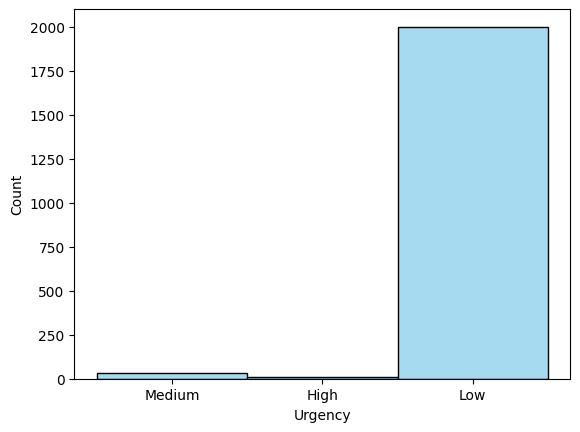

In [47]:
#copotin low dengan df yang asli lalu concat dengan df urgency low yang disample
df = df[df['Urgency'] != 'Low']
df = pd.concat([df,df_classLow], axis='rows')
print(df.Urgency.value_counts() / len(df.Urgency) * 100)
sns.histplot(data=df, x='Urgency', color='skyblue')

### - Encoding Urgency

In [48]:
def encodeUrgency(x) :
    if x=='Low':
        return 1
    if x=='Medium' :
        return 2
    if x=='High' :
        return 3

In [49]:
df['Urgency'] = df['Urgency'].map(encodeUrgency)
df['Urgency'].value_counts()

Urgency
1    2000
2      33
3      11
Name: count, dtype: int64

### - Encoding Text

Load Word Embedding Models

In [50]:
#load embeding models
path = r"C:\Users\Ibrahim Saputra\OneDrive\Documents\Kuliah\Semester 4\BIS\BIS_models-making\wordembedding.fasttext"
wv = FastText.load(path).wv

Word vector to Sentence vector

In [51]:
#fungsi untuk mengubah word vector menjadi sentence vector
# dengan return np.array 2D berisikan word yang sudah di tokenize dan di lower lalu ubah ke vector satukan dengan cara di rata rata dan satukan lagi menjadi sentence
def vectorize(text,wvmodels) :
    vecs = [wvmodels[word.lower()] for word in nltk.word_tokenize(text)]
    vec = np.mean(vecs,axis=0)
    return vec

In [52]:
#buat variable titlevecs berisikan array dari title yang sudah di tokenize di lower dan disatukan lalu di rata rata dengan membentuk shape 1 baris 300 kolom untuk setiap title
titleVecs = [vectorize(title,wv) for title in df.Title]
titleVecs = np.array(titleVecs)
print(titleVecs)
print(titleVecs.shape)

[[ 0.1418723   0.44779882  0.18818147 ... -0.36829242  0.13194008
   0.35238585]
 [ 0.24422304  1.0584408   0.5804253  ... -0.397326    0.2529584
   0.48741388]
 [ 0.22759148  1.0682901   0.60084414 ... -0.4079904   0.2520011
   0.48553118]
 ...
 [ 0.25155857  0.58295566  0.28752208 ... -0.4327733   0.22334667
   0.47229108]
 [ 0.19633622  0.8093017   0.3188223  ... -0.55484736  0.22974457
   0.6383415 ]
 [ 0.27559006  1.4395243   0.611986   ... -0.98445225  0.39977515
   1.0024344 ]]
(2044, 300)


### - Feature Label Split

In [53]:
X = titleVecs
y = df.Urgency

### - OverSampling

In [54]:
sm = SMOTE(random_state=30, k_neighbors=5)
X_sm,y_sm =sm.fit_resample(X,y)
print('Before :')
print('X =',X.shape)
print('y =',y.shape)
print("-------------------------------------")
print('After :')
print('X =',X_sm.shape)
print('y =',y_sm.shape)

Before :
X = (2044, 300)
y = (2044,)
-------------------------------------
After :
X = (6000, 300)
y = (6000,)


Urgency
2    33.333333
3    33.333333
1    33.333333
Name: count, dtype: float64


<Axes: xlabel='Urgency', ylabel='Count'>

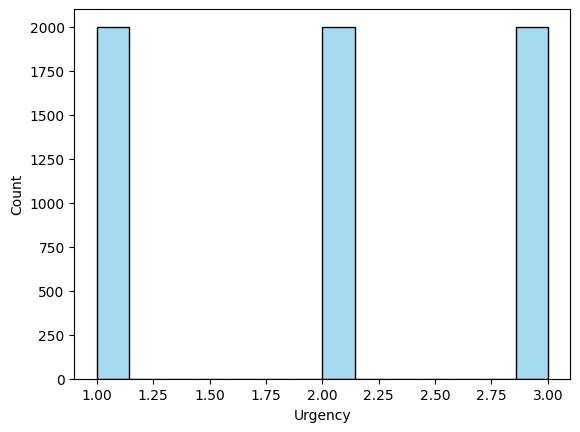

In [55]:
print(y_sm.value_counts() / len(y_sm) * 100)
sns.histplot(data=y_sm, color='skyblue')

# 5. Modeling Machine Learning (KNN)

### - Train Test Split

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_sm,y_sm, test_size=0.2, random_state=10)
print('y_Train :',y_train.value_counts())
print('---------------------------------')
print('y_Test :',y_test.value_counts())

y_Train : Urgency
3    1623
2    1598
1    1579
Name: count, dtype: int64
---------------------------------
y_Test : Urgency
1    421
2    402
3    377
Name: count, dtype: int64


### - Training KNN

In [80]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier()

# 6. Validation

### - score basic train & test split

In [81]:
print("Training Score : ",knn.score(X_train,y_train))
print("Testing Score : ", knn.score(X_test,y_test))

Training Score :  0.9716666666666667
Testing Score :  0.9633333333333334


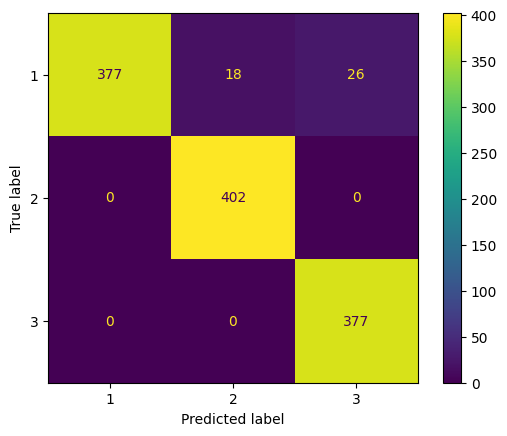

In [82]:
y_pred = knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.show()

### - K-Fold Cross Validation

In [87]:
print("======================= CV Train ============================")
print("Akurasi sebanyak 3 lipatan : ", cross_val_score(knn, X_train,y_train, cv=3))
print("Rata Rata Akurasi CV : ", np.mean(cross_val_score(knn, X_train,y_train, cv=3)))
print("")
print("======================= CV Test =============================")
print("Akurasi sebanyak 3 lipatan : ", cross_val_score(knn, X_test,y_test, cv=3))
print("Rata Rata Akurasi CV : ", np.mean(cross_val_score(knn, X_test,y_test, cv=3)))

======================= CV Train ============================
Akurasi sebanyak 3 lipatan :  [0.961875 0.96     0.95125 ]
Rata Rata Akurasi CV :  0.9577083333333333

======================= CV Test =============================
Akurasi sebanyak 3 lipatan :  [0.9175 0.93   0.9275]
Rata Rata Akurasi CV :  0.9250000000000002


### - Improve Model

- Tunning manual

In [61]:
k = range(5,50,2)
train_score = []
test_score = []

for i in k :
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    train_score.append(knn.score(X_train,y_train))
    test_score.append(knn.score(X_test,y_test))

n_neighbors =  5
Max Train Score =  0.9716666666666667
Max Test Score =  0.9633333333333334


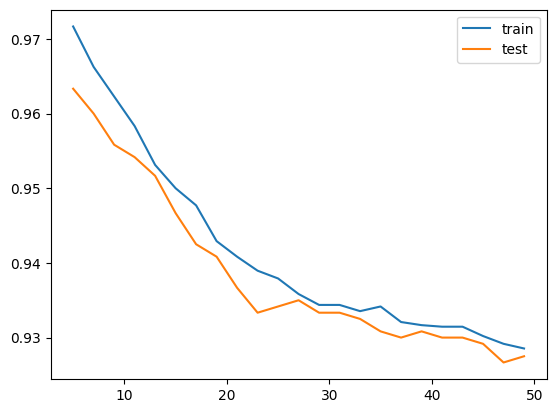

In [69]:
plt.plot(k, train_score, label = "train")
plt.plot(k, test_score, label = "test")
plt.legend()

print("n_neighbors = ", k[np.argmax(test_score)])
print("Max Train Score = ", np.max(train_score))
print("Max Test Score = ", np.max(test_score))

- Tunning dengan GridSearchCV

In [63]:
KNNparameter = {
    "n_neighbors" : range(5,50,2),
    "weights" : ['uniform', 'distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}
knn_tunning = GridSearchCV(KNeighborsClassifier(),KNNparameter, cv=3, n_jobs=-1)
knn_tunning.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': range(5, 50, 2),
                         'weights': ['uniform', 'distance']})

In [64]:
reports = pd.DataFrame(knn_tunning.cv_results_).sort_values("rank_test_score")
print("best Parameter :" , knn_tunning.best_params_)

#Overfit?
print("Training Score : ",reports.iloc[0,11])
print("Testing Score : ", knn_tunning.score(X_test,y_test))

best Parameter : {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Training Score :  0.961875
Testing Score :  0.9675


# 7. Sanity Check

In [65]:
text = [['Kirim Ulang Email...'], #Low
        ['matikan akun!!'], #Low
        ['Kendala aplikasi          airlis'], #Low
        ['Reject by djp'], #Medium
        ['preloading 30 RT pengganti sisna jakarta timur/;'], #High
        ['[URGENT] layanan airlis ga bisa dibuka kacau banget'] #High
        ]
text = pd.DataFrame(text, columns=['input'])
#Remove Punct
text['input'] =text['input'].map(rmPunct)
#Encode
textVecs = [vectorize(text,wv) for text in text['input']]
textVecs = np.array(textVecs)
knn_tunning.predict(textVecs)

array([1, 1, 1, 2, 3, 3], dtype=int64)

# 8. Import Model

In [66]:
dump(knn_tunning,'Text-Classification-Models.joblib')

['Text-Classification-Models.joblib']